# COVSCO:

## Data Exploration

### The data

In [95]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# =============================================================================
# Imports #%%
# =============================================================================
#part| #%%
from datetime import datetime

import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import FastICA
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
from tpot import TPOTRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf 
from tensorflow.keras import callbacks
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from copy import copy
import joblib as joblib
import matplotlib.pyplot as plt

def max_normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def mse(ground_truth, predictions):
    diff = (ground_truth - predictions)**2
    return diff.mean()

def mae(ground_truth, predictions):
    diff = abs(ground_truth - predictions)
    return diff.mean()

df = pd.read_csv("../data/train/all_data_merged/fr/Enriched_Covid_history_data.csv")
df = df.dropna()
df["all_day_bing_tiles_visited_relative_change"]=df["all_day_bing_tiles_visited_relative_change"].astype(float)
df["all_day_ratio_single_tile_users"]=df["all_day_ratio_single_tile_users"].astype(float)
df["time"]=pd.to_datetime(df["time"])
print(df)
columnstonormalize = ['pm25', 'no2','o3','pm10','co','pm257davg','no27davg','o37davg','co7davg', 'pm107davg','1MMaxpm25','1MMaxpm10','1MMaxo3','1MMaxno2','1MMaxco']
# for c in columnstonormalize:
#     df[c]=max_normalize(df[c])

featuresandtarget = ['idx', 'pm25', 'no2',\
'o3','pm10','co',\
    'pm257davg','no27davg',\
    'o37davg','co7davg', 'pm107davg',\
        'hospiprevday','covidpostestprevday',\
            'all_day_bing_tiles_visited_relative_change','all_day_ratio_single_tile_users','vac1nb', 'vac2nb',\
                 'Insuffisance respiratoire chronique grave (ALD14)', \
                     'Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)',\
                         'Smokers',\
                             "minority",\
                                  "Nb_susp_501Y_V1","Nb_susp_501Y_V2_3",\
                                      '1MMaxpm25','1MMaxpm10','1MMaxo3','1MMaxno2','1MMaxco',\
                                          'pm251Mavg','no21Mavg','o31Mavg','pm101Mavg','co1Mavg',\
                                           'newhospi'\

                            ]
                                            
features = ['idx', 'pm25', 'no2',
'o3','pm10','co',\
    'pm257davg','no27davg',\
    'o37davg','co7davg', 'pm107davg',\
        'hospiprevday','covidpostestprevday',\
            'all_day_bing_tiles_visited_relative_change','all_day_ratio_single_tile_users','vac1nb', 'vac2nb',\
                 'Insuffisance respiratoire chronique grave (ALD14)', \
                     'Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)',\
                         'Smokers',\
                         "minority",\
                             "Nb_susp_501Y_V1","Nb_susp_501Y_V2_3",
                                 '1MMaxpm25','1MMaxpm10','1MMaxo3','1MMaxno2','1MMaxco',\
                                 'pm251Mavg','no21Mavg','o31Mavg','pm101Mavg','co1Mavg'\
                                     \
                            ]


              nom  numero       time  hospi  reanim  newhospi  newreanim  \
1             Ain     1.0 2020-05-14  137.0     8.0       4.0        0.0   
2             Ain     1.0 2020-05-15  135.0     7.0       4.0        0.0   
3             Ain     1.0 2020-05-16  134.0     6.0       1.0        0.0   
4             Ain     1.0 2020-05-17  133.0     6.0       1.0        0.0   
5             Ain     1.0 2020-05-18  132.0     6.0       1.0        0.0   
...           ...     ...        ...    ...     ...       ...        ...   
30680  Val-d'Oise    95.0 2021-03-27  659.0    79.0      43.0        7.0   
30681  Val-d'Oise    95.0 2021-03-28  667.0    81.0      38.0        7.0   
30682  Val-d'Oise    95.0 2021-03-29  680.0    76.0      44.0        4.0   
30683  Val-d'Oise    95.0 2021-03-30  688.0    75.0      88.0        5.0   
30684  Val-d'Oise    95.0 2021-03-31  698.0    77.0      83.0        7.0   

        deces  gueris  dep_num  ...  Code département  \
1        88.0   318.0      1.0

In [77]:
data = df[featuresandtarget]
start = df["time"].min()

# €df_ts = df.resample('W', how= 'max')
# €df_ts.plot(kind='bar', stacked=True)

### Ozone (O3) and the number of severe COVID19 cases leading to hospitalization

#### Departement 75: Paris region Ile de France

<ipython-input-74-be6d2873c28b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["o37davg"]=max_normalize(data["o37davg"])
<ipython-input-74-be6d2873c28b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["o3"]=max_normalize(data["o3"])
<ipython-input-74-be6d2873c28b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<AxesSubplot:>

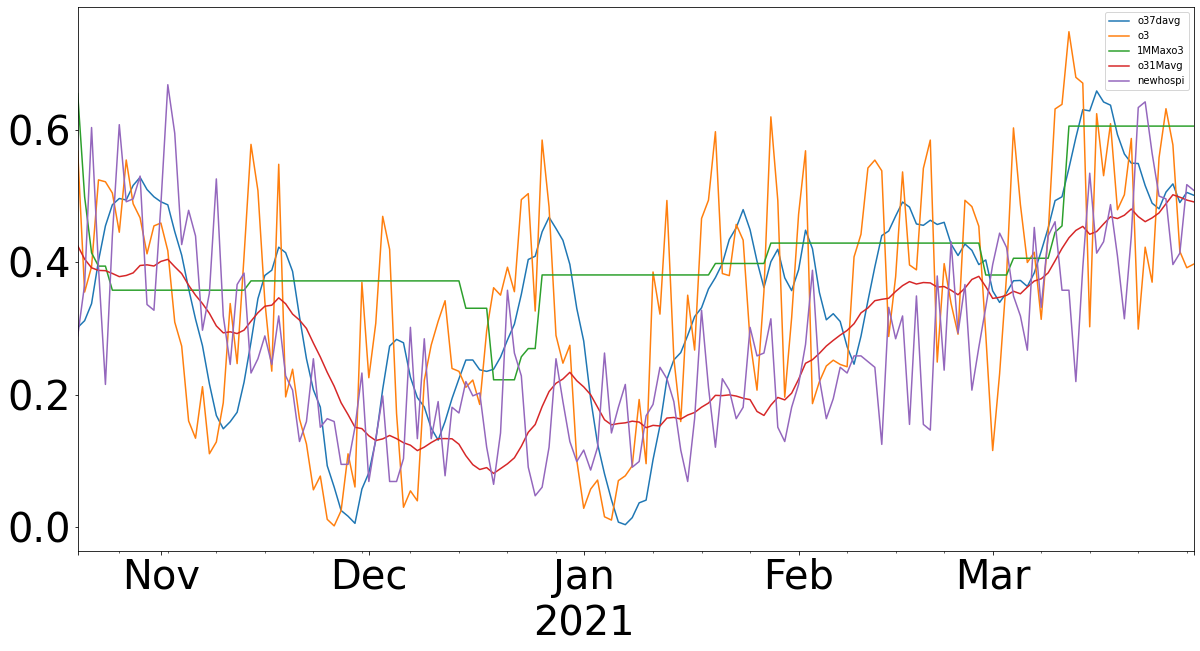

In [74]:
data = df[["numero","time","o37davg","o3","1MMaxo3",'o31Mavg','newhospi']]
data["o37davg"]=max_normalize(data["o37davg"])
data["o3"]=max_normalize(data["o3"])
data["1MMaxo3"]=max_normalize(data["1MMaxo3"])
data["o31Mavg"]=max_normalize(data["o31Mavg"])
data["newhospi"]=max_normalize(data["newhospi"])
data = data[data["numero"]==75][["o37davg","o3","1MMaxo3",'o31Mavg','newhospi']]
idx = pd.date_range(pd.to_datetime("2020-10-20"), periods= 162).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### Departement 83: Var region PACA

In [60]:
data = df[["numero","time","o37davg","o3","1MMaxo3",'o31Mavg','newhospi']]
data["o37davg"]=max_normalize(data["o37davg"])
data["o3"]=max_normalize(data["o3"])
data["1MMaxo3"]=max_normalize(data["1MMaxo3"])
data["o37davg"]=max_normalize(data["o37davg"])
data["o31Mavg"]=max_normalize(data["o31Mavg"])
data["newhospi"]=max_normalize(data["newhospi"])
data = data[data["numero"]==83][["o37davg","o3","1MMaxo3",'o31Mavg','newhospi']]
idx = pd.date_range(start, periods= 321).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

<ipython-input-60-078e23c63d15>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["o37davg"]=max_normalize(data["o37davg"])
<ipython-input-60-078e23c63d15>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["o3"]=max_normalize(data["o3"])
<ipython-input-60-078e23c63d15>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

ValueError: Length mismatch: Expected axis has 162 elements, new values have 321 elements

### Nitrogen dioxide (NO2) and the number of severe COVID19 cases leading to hospitalization

#### Departement 75: Paris region Ile de France

<ipython-input-45-8d36136d1b31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["no2"]=max_normalize(data["no2"])
<ipython-input-45-8d36136d1b31>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["1MMaxno2"]=max_normalize(data["1MMaxno2"])
<ipython-input-45-8d36136d1b31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

<AxesSubplot:>

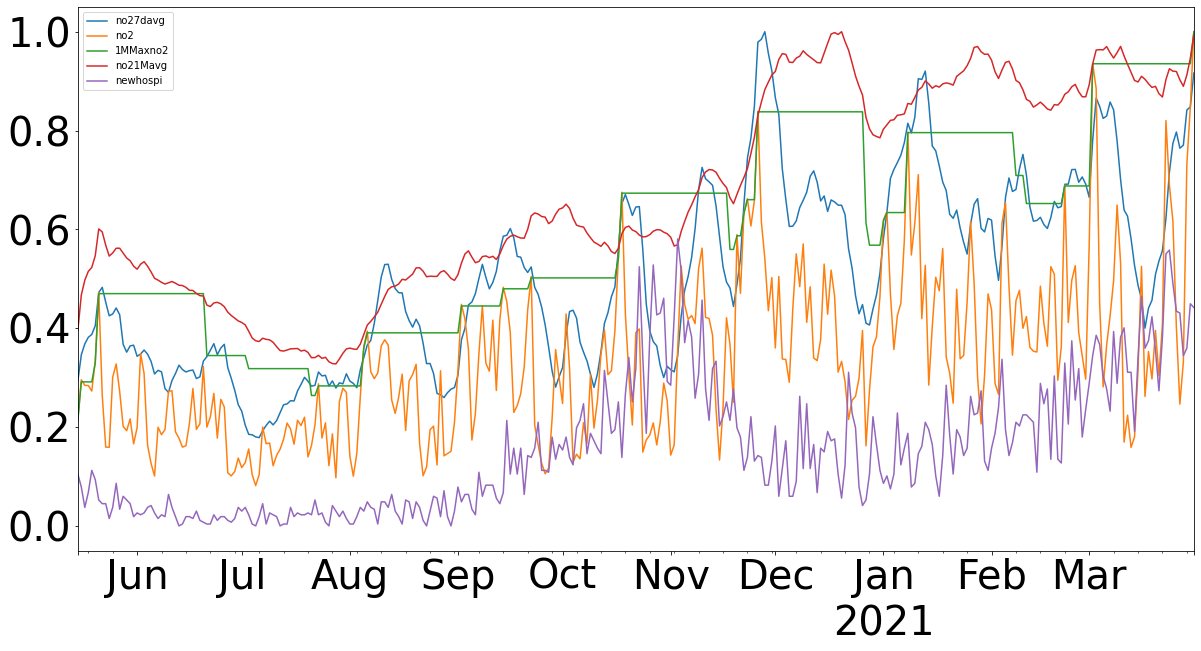

In [45]:
data = df[["numero","time","no27davg","no2","1MMaxno2",'no21Mavg','newhospi']]
data["no2"]=max_normalize(data["no2"])
data["1MMaxno2"]=max_normalize(data["1MMaxno2"])
data["no27davg"]=max_normalize(data["no27davg"])
data["no21Mavg"]=max_normalize(data["no21Mavg"])
data["newhospi"]=max_normalize(data["newhospi"])
data = data[data["numero"]==75][["no27davg","no2","1MMaxno2",'no21Mavg','newhospi']]
idx = pd.date_range(start, periods= 321).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### Departement 83: Var region PACA


<ipython-input-43-8d7b0129b7fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["no27davg"]=max_normalize(data["no27davg"])
<ipython-input-43-8d7b0129b7fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["no2"]=max_normalize(data["no2"])
<ipython-input-43-8d7b0129b7fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

<AxesSubplot:>

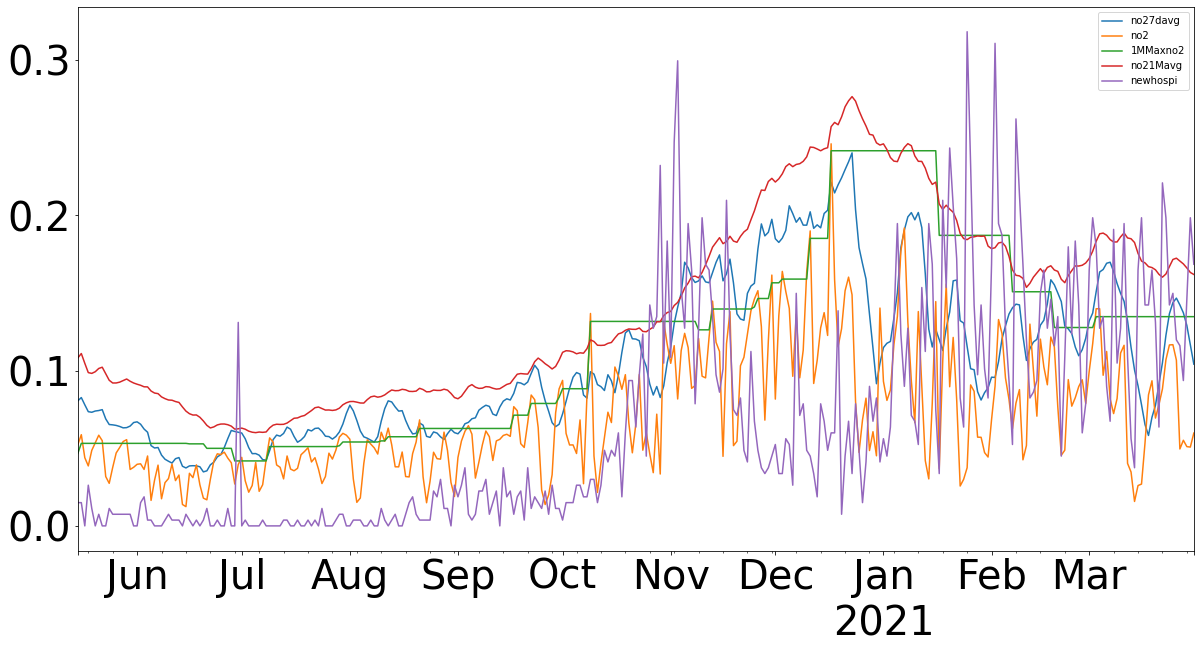

In [43]:
data = df[["numero","time","no27davg","no2","1MMaxno2",'no21Mavg','newhospi']]
data["no27davg"]=max_normalize(data["no27davg"])
data["no2"]=max_normalize(data["no2"])
data["1MMaxno2"]=max_normalize(data["1MMaxno2"])
data["no27davg"]=max_normalize(data["no27davg"])
data["no21Mavg"]=max_normalize(data["no21Mavg"])
data["newhospi"]=max_normalize(data["newhospi"])
data = data[data["numero"]==83][["no27davg","no2","1MMaxno2",'no21Mavg','newhospi']]
idx = pd.date_range(start, periods= 321).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

### PM2.5 and the number of severe COVID19 cases leading to hospitalization

#### Departement 75: Paris region Ile de France

<ipython-input-46-e00fe085bb2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["pm257davg"]=max_normalize(data["pm257davg"])
<ipython-input-46-e00fe085bb2c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["pm25"]=max_normalize(data["pm25"])
<ipython-input-46-e00fe085bb2c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

<AxesSubplot:>

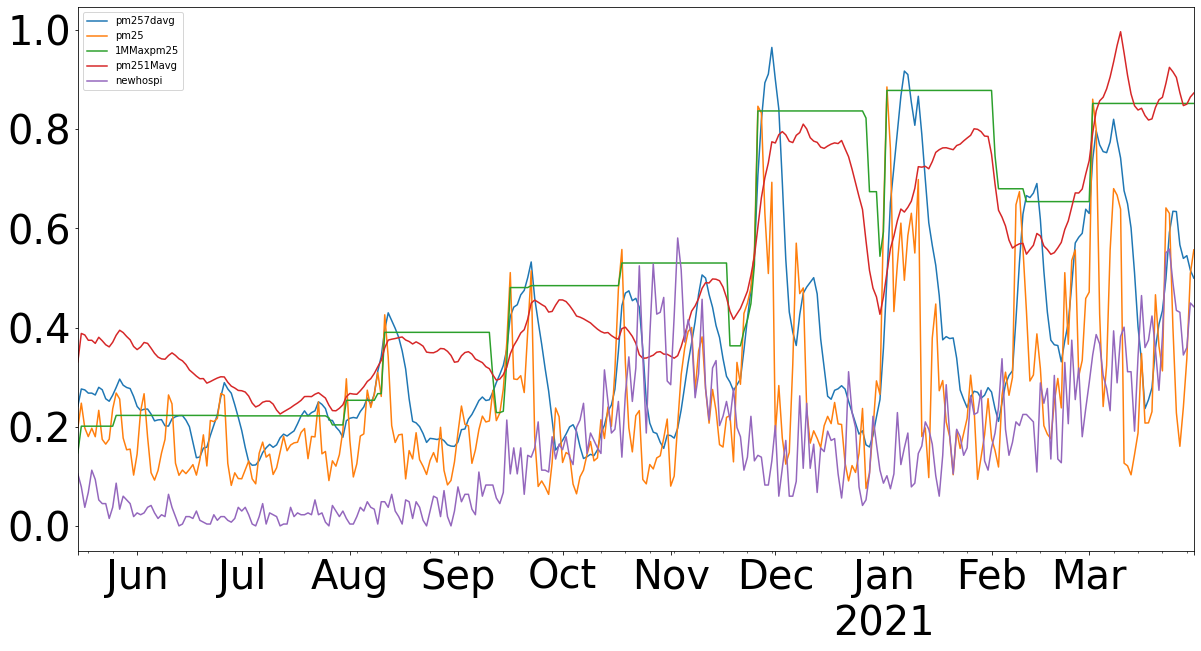

In [46]:
data = df[["numero","time","pm257davg","pm25","1MMaxpm25",'pm251Mavg','newhospi']]
data["pm257davg"]=max_normalize(data["pm257davg"])
data["pm25"]=max_normalize(data["pm25"])
data["1MMaxpm25"]=max_normalize(data["1MMaxpm25"])
data["pm257davg"]=max_normalize(data["pm257davg"])
data["pm251Mavg"]=max_normalize(data["pm251Mavg"])
data["newhospi"]=max_normalize(data["newhospi"])
data = data[data["numero"]==75][["pm257davg","pm25","1MMaxpm25",'pm251Mavg','newhospi']]
idx = pd.date_range(start, periods= 321).tolist()
data.index = idx
data.plot.line(figsize = (20,10))


#### Departement 83: Var region PACA

<ipython-input-8-7c535923ac68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["pm257davg"]=max_normalize(data["pm257davg"])
<ipython-input-8-7c535923ac68>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["pm25"]=max_normalize(data["pm25"])
<ipython-input-8-7c535923ac68>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<AxesSubplot:>

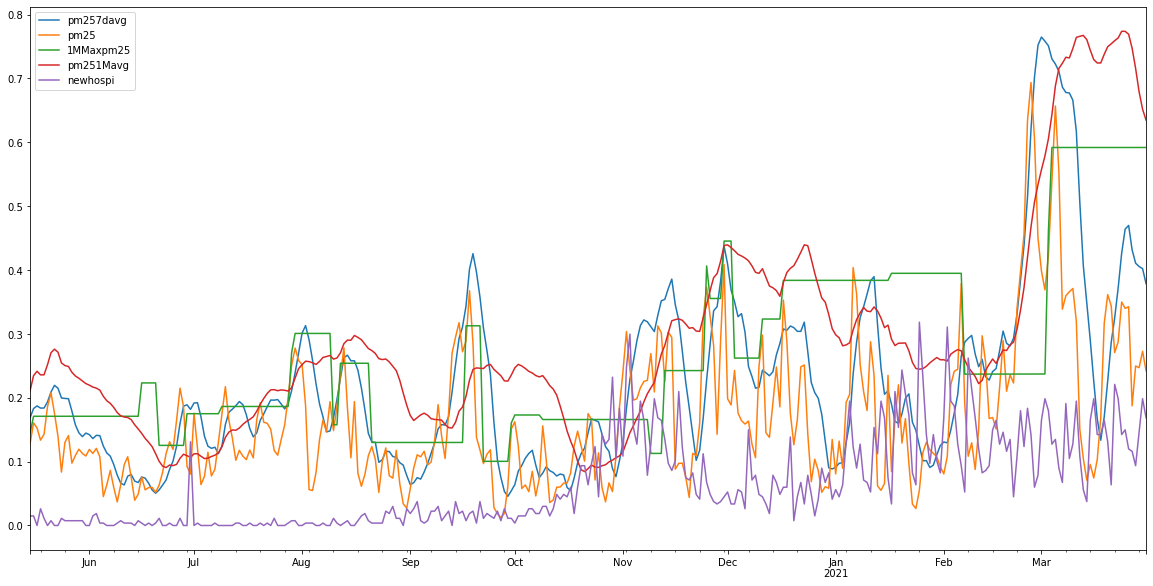

In [8]:
data = df[["numero","time","pm257davg","pm25","1MMaxpm25",'pm251Mavg','newhospi']]
data["pm257davg"]=max_normalize(data["pm257davg"])
data["pm25"]=max_normalize(data["pm25"])
data["1MMaxpm25"]=max_normalize(data["1MMaxpm25"])
data["pm257davg"]=max_normalize(data["pm257davg"])
data["pm251Mavg"]=max_normalize(data["pm251Mavg"])
data["newhospi"]=max_normalize(data["newhospi"])
data = data[data["numero"]==83][["pm257davg","pm25","1MMaxpm25",'pm251Mavg','newhospi']]
idx = pd.date_range(start, periods= 321).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

## The Model: Scikit Learn's ExtratreesRegressor

In [69]:
df

,nom,numero,time,hospi,reanim,newhospi,newreanim,deces,gueris,dep_num,...,P,covidpostestprevday,Code département,Insuffisance respiratoire chronique grave (ALD14),"Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)",Region_y,Departement_y,depnum_y,Smokers,minority
1,Ain,1.0,2020-05-14,137.0,8.0,4.0,0.0,88.0,318.0,1.0,...,18,18.0,1,2330,10080,Auvergne-Rhône-Alpes,Ain,1,0.262,54821.0
2,Ain,1.0,2020-05-15,135.0,7.0,4.0,0.0,89.0,323.0,1.0,...,10,18.0,1,2330,10080,Auvergne-Rhône-Alpes,Ain,1,0.262,54821.0
3,Ain,1.0,2020-05-16,134.0,6.0,1.0,0.0,90.0,325.0,1.0,...,0,10.0,1,2330,10080,Auvergne-Rhône-Alpes,Ain,1,0.262,54821.0
4,Ain,1.0,2020-05-17,133.0,6.0,1.0,0.0,90.0,326.0,1.0,...,0,0.0,1,2330,10080,Auvergne-Rhône-Alpes,Ain,1,0.262,54821.0
5,Ain,1.0,2020-05-18,132.0,6.0,1.0,0.0,90.0,331.0,1.0,...,22,0.0,1,2330,10080,Auvergne-Rhône-Alpes,Ain,1,0.262,54821.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30680,Val-d'Oise,95.0,2021-03-27,659.0,79.0,43.0,7.0,1603.0,6857.0,95.0,...,2256,3338.0,95,9270,16410,Île-de-France,Val-d'Oise,95,0.213,161947.0
30681,Val-d'Oise,95.0,2021-03-28,667.0,81.0,38.0,7.0,1606.0,6882.0,95.0,...,328,2256.0,95,9270,16410,Île-de-France,Val-d'Oise,95,0.213,161947.0
30682,Val-d'Oise,95.0,2021-03-29,680.0,76.0,44.0,4.0,1615.0,6902.0,95.0,...,4529,328.0,95,9270,16410,Île-de-France,Val-d'Oise,95,0.213,161947.0
30683,Val-d'Oise,95.0,2021-03-30,688.0,75.0,88.0,5.0,1632.0,6964.0,95.0,...,3712,4529.0,95,9270,16410,Île-de-France,Val-d'Oise,95,0.213,161947.0


In [97]:


X1=df[['idx', 'pm25', 'no2']]
X2=df[features]

y= df['newhospi']
stats = df[["newhospi"]]
print("Average number of new hospitalisations",df['newhospi'].mean())
print(stats.describe())

# Hold-out
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.33)
print("\n")

print(" Scikit Learn ExtratreesRegressor")
ETregr = ExtraTreesRegressor()
ETregr.fit(X_train2, y_train2)
predET = ETregr.predict(X_test2).round(0)
predETdf = pd.DataFrame(predET)
predETdf.columns = ["prednewhospi"]
featuresandtargetdf = X_test2.merge(y_test2, left_on = X_test2.index, right_on = y_test2.index)
featuresandtargetdf["prednewhospi"]=predETdf["prednewhospi"].round(0)
featuresandtargetdf.to_csv("../predictions/fr/new_hospi_predictions.csv", index = False)
ETMSE = mse(y_test2, predET)
ETMAE = mae(y_test2, predET)

print("MSE")
print(ETMSE)
print("MAE")
print(ETMAE)
print("\n")


print("T-Pot exported current best pipeline")
# Average CV score on the training set was: -94.5319545151712
#exported_pipeline = ExtraTreesRegressor(bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=4, n_estimators=100)
exported_pipeline = make_pipeline(
    StandardScaler(),
    RobustScaler(),
    GradientBoostingRegressor(alpha=0.75, learning_rate=0.1, loss="ls", max_depth=8, max_features=0.35000000000000003, min_samples_leaf=14, min_samples_split=18, n_estimators=100, subsample=0.9500000000000001)
)
#Fix random state for all the steps in exported pipeline
#set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train2, y_train2)
predictions = exported_pipeline.predict(X_test2)
TPOTMSE = mse(y_test2, predictions)
TPOTMAE = mae (y_test2, predictions)
print("MSE:")
print(TPOTMSE)
print("MAE:")
print(TPOTMAE)
print("\n")

# print("Scikit Learn RandomForestRegressor without feature engineering")
# regr = RandomForestRegressor()
# regr.fit(X_train, y_train)
# pred = regr.predict(X_test).round(0)
# RFRMSE = mse(y_test, pred)
# print(RFRMSE)
# print("Average error on new number of hospitalizations per day:", round(RFRMSE ** 0.5,0))
#print("\n")

# print(" Scikit Learn RandomForestRegressor")
# regr2 = RandomForestRegressor()
# regr2.fit(X_train2, y_train2)
# pred2 = regr2.predict(X_test2).round(0)
# RFRMSE2 = mse(y_test2, pred2)
# RFMAE2 = mae(y_test2, pred2)
# print("MSE:")
# print(RFRMSE2)
# print("MAE")
# print(RFMAE2)
# print("\n")

# print("GradientBoostingRegressor Model")
# model = GradientBoostingRegressor(
#     n_estimators=100, 
#     learning_rate=0.1
# )
# model.fit(X_train2,y_train2)
# pred4 = model.predict(X_test2).round(0)
# MSE4 = mse(y_test2, pred4)
# MAE4 = mae(y_test2, pred4)
# print("MSE:")
# print(MSE4)
# print("MAE:")
# print(MAE4)



# print("\n")
# print("DecisionTreeRegressor Model")
# regr2 = DecisionTreeRegressor()
# regr2.fit(X_train2, y_train2)
# pred2 = regr2.predict(X_test2).round(0)
# RFRMSE2 = mse(y_test2, pred2)
# print(RFRMSE2)
# print("Average error on new number of hospitalizations per day:", round(RFRMSE2 ** 0.5,0))

print("\n")
print("XGBoost Regressor Model")
xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

xgb_model.fit(X_train2, y_train2)
pred3 = xgb_model.predict(X_test2).round(0)
RFRMSE3 = mse(y_test2, pred3)
XGBMAE = mae(y_test2, pred3)
print("MSE:")
print(RFRMSE3)
print("MAE:")
print(XGBMAE)
print("\n")

print("VotingRegressor")
ensemble = VotingRegressor(
    estimators = [("TPET",exported_pipeline),("xgbr",xgb_model)],
   )

ensemble.fit(X_train2, y_train2)
predvot = ensemble.predict(X_test2).round(0)
MSE5 = mse(y_test2,predvot)
MAE5 = mae(y_test2,predvot)
print("MSE:")
print(MSE5)
print("MAE:")
print(MAE5)
for alg in ensemble.named_estimators:
    clf = ensemble.named_estimators[alg]
    # extract feature importance for clf
    # Note different algorithms have different 
    # methods for feature importance
    print(clf)
    
print("\n")



Average number of new hospitalisations 9.589212160836874
           newhospi
count  30590.000000
mean       9.589212
std       16.988266
min        0.000000
25%        0.000000
50%        3.000000
75%       11.000000
max      267.000000


 Scikit Learn ExtratreesRegressor
MSE
43.04705299653294
MAE
3.6172362555720654


T-Pot exported current best pipeline
MSE:
42.07972532400724
MAE:
3.5793026456821195




XGBoost Regressor Model
MSE:
44.7482912332838
MAE:
3.6481426448736998


VotingRegressor
MSE:
41.533432392273404
MAE:
3.540564635958395
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('robustscaler', RobustScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(alpha=0.75, max_depth=8,
                                           max_features=0.35000000000000003,
                                           min_samples_leaf=14,
                                           min_samples_split=18,
                                 

In [68]:
X2

,idx,pm25,no2,o3,pm10,co,pm257davg,no27davg,o37davg,co7davg,...,1MMaxpm25,1MMaxpm10,1MMaxo3,1MMaxno2,1MMaxco,pm251Mavg,no21Mavg,o31Mavg,pm101Mavg,co1Mavg
159,657907.0,6.737591,3.484633,82.740733,12.517437,131.057597,6.403713,5.084454,51.549126,178.662710,...,10.016783,13.785627,82.740733,9.032311,203.934978,5.228379,5.174142,51.683668,7.714685,161.415241
160,657907.0,10.844402,5.787471,66.039559,17.847794,135.610097,7.047588,5.004027,55.780852,171.092193,...,10.844402,17.847794,82.740733,9.032311,203.934978,5.360754,5.177500,51.927030,7.978897,160.704224
161,657907.0,6.681308,7.628235,54.798256,10.070128,162.365053,7.302892,5.236041,58.933208,167.844755,...,10.844402,17.847794,82.740733,9.032311,203.934978,5.394663,5.255842,51.860062,8.055877,161.068313
162,657907.0,4.785762,5.027647,48.535472,6.236821,165.936881,7.047602,4.988554,61.517733,163.712759,...,10.844402,17.847794,82.740733,9.032311,203.934978,5.351164,5.262830,51.057462,7.976917,161.811620
163,657907.0,4.631508,3.952503,56.842632,6.784782,147.072636,6.833717,4.914990,62.737708,155.589567,...,10.844402,17.847794,82.740733,9.032311,203.934978,5.372148,5.253405,50.876127,7.991394,162.187255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30490,1260269.0,6.100140,6.627001,70.229467,11.613934,185.482428,14.467708,16.237065,58.907952,210.161923,...,34.844152,53.422224,80.500790,51.599818,343.299021,14.580851,14.493739,56.915039,21.526604,207.123258
30491,1260269.0,8.425896,9.099569,68.209629,13.743489,193.139682,13.912282,16.429180,59.975429,212.799404,...,34.844152,53.422224,80.500790,51.599818,343.299021,14.195306,14.223872,57.801110,20.640382,206.960739
30492,1260269.0,13.033086,29.526526,54.441418,18.517216,237.388093,14.180923,19.142370,57.971645,217.938592,...,34.844152,53.422224,80.500790,51.599818,343.299021,14.249303,14.775230,57.704602,20.672684,207.544318
30493,1260269.0,21.792762,51.437356,40.131381,30.011262,307.382279,13.775409,21.747143,57.702312,221.278882,...,34.844152,53.422224,80.500790,51.599818,343.299021,14.525749,16.057324,57.291931,20.997907,210.476992


In [109]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

exported_pipeline = make_pipeline(
    #StandardScaler(),
    #RobustScaler(),
    GradientBoostingRegressor(alpha=0.75, learning_rate=0.1, loss="lad", max_depth=8, max_features=0.33, min_samples_leaf=14, min_samples_split=18, n_estimators=100, subsample=0.9500000000000001)
)
xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

ensemble = VotingRegressor(
    estimators = [("TPET",exported_pipeline),("xgbr",xgb_model)],
   )
scores = cross_validate(ensemble, X2, y, cv=5,
                        scoring=('neg_mean_squared_error'),
                         return_train_score=True)
print(scores)

{'fit_time': array([31.35030365, 31.57580614, 32.61417937, 32.12739182, 33.0952692 ]), 'score_time': array([0.07103896, 0.0703938 , 0.0739789 , 0.07619262, 0.09660435]), 'test_score': array([-104.53057839,  -74.46311767,  -19.42783486,  -16.92768659,
       -117.25704336]), 'train_score': array([-20.79890774, -21.52786613, -27.74087135, -27.18107869,
       -20.65305949])}


In [107]:
print(scores["test_score"].mean())

-68.78649674757457


In [12]:
ensemble.fit(X_train2, y_train2)

VotingRegressor(estimators=[('TPET',
                             ExtraTreesRegressor(max_features=0.7000000000000001,
                                                 min_samples_split=4)),
                            ('xgbr',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.25, max_delta_step=0,
                                          max_depth=6, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=1,
    

In [13]:
exported_pipeline = ExtraTreesRegressor(bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=4, n_estimators=100)

xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

exported_pipeline.fit(X_train2,y_train2)
xgb_model.fit(X_train2,y_train2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Scikit Learn - Extra Trees Regressor Feature importance report: [0.04950507 0.00585139 0.0065436  0.00688077 0.00562235 0.00878221
 0.00576629 0.00578812 0.00790842 0.01173602 0.00547165 0.27425235
 0.27272716 0.0121183  0.02379616 0.00623318 0.00444235 0.02946804
 0.03125372 0.00650333 0.03573831 0.00691661 0.00325604 0.00782057
 0.0057902  0.04326828 0.02590987 0.01089929 0.0107617  0.01362559
 0.03088762 0.00707715 0.01739828]
                                                index  feature_importance
22                                  Nb_susp_501Y_V2_3            0.003256
16                                             vac2nb            0.004442
10                                          pm107davg            0.005472
4                                                pm10            0.005622
6                                           pm257davg            0.005766
7                                            no27davg            0.005788
24                                          1MMa

<Figure size 900x600 with 0 Axes>

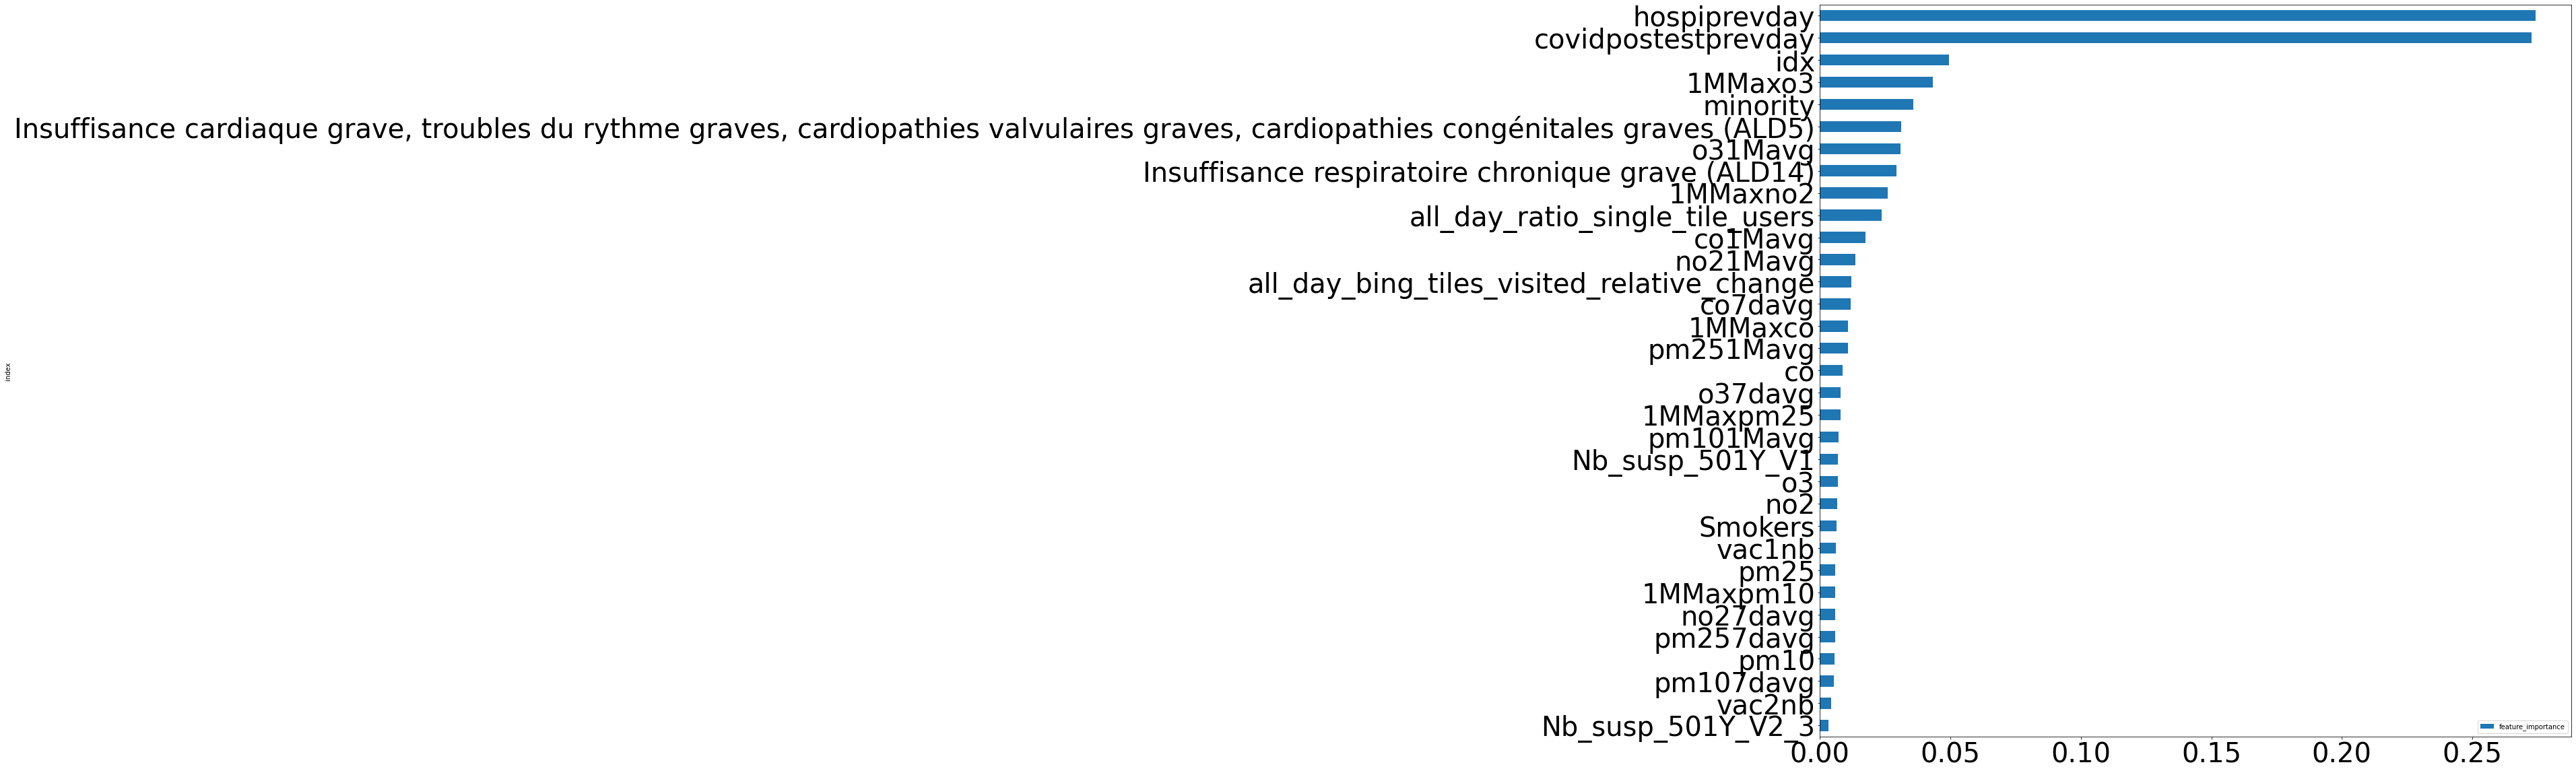

XGBoost- Extreme Gradient Regressor Feature importance report: [0.00869425 0.00417891 0.00483762 0.00643562 0.0065102  0.00702025
 0.00547992 0.00516363 0.00735803 0.01398635 0.00592853 0.22316639
 0.36379156 0.00947689 0.03047437 0.01035038 0.0177485  0.01343058
 0.01082395 0.00619931 0.00954481 0.02709178 0.02963594 0.00826238
 0.004119   0.06315742 0.01045964 0.00998687 0.0143854  0.00979177
 0.02002813 0.01404676 0.01843481]
                                                index  feature_importance
24                                          1MMaxpm10            0.004119
1                                                pm25            0.004179
2                                                 no2            0.004838
7                                            no27davg            0.005164
6                                           pm257davg            0.005480
10                                          pm107davg            0.005929
19                                            Smo

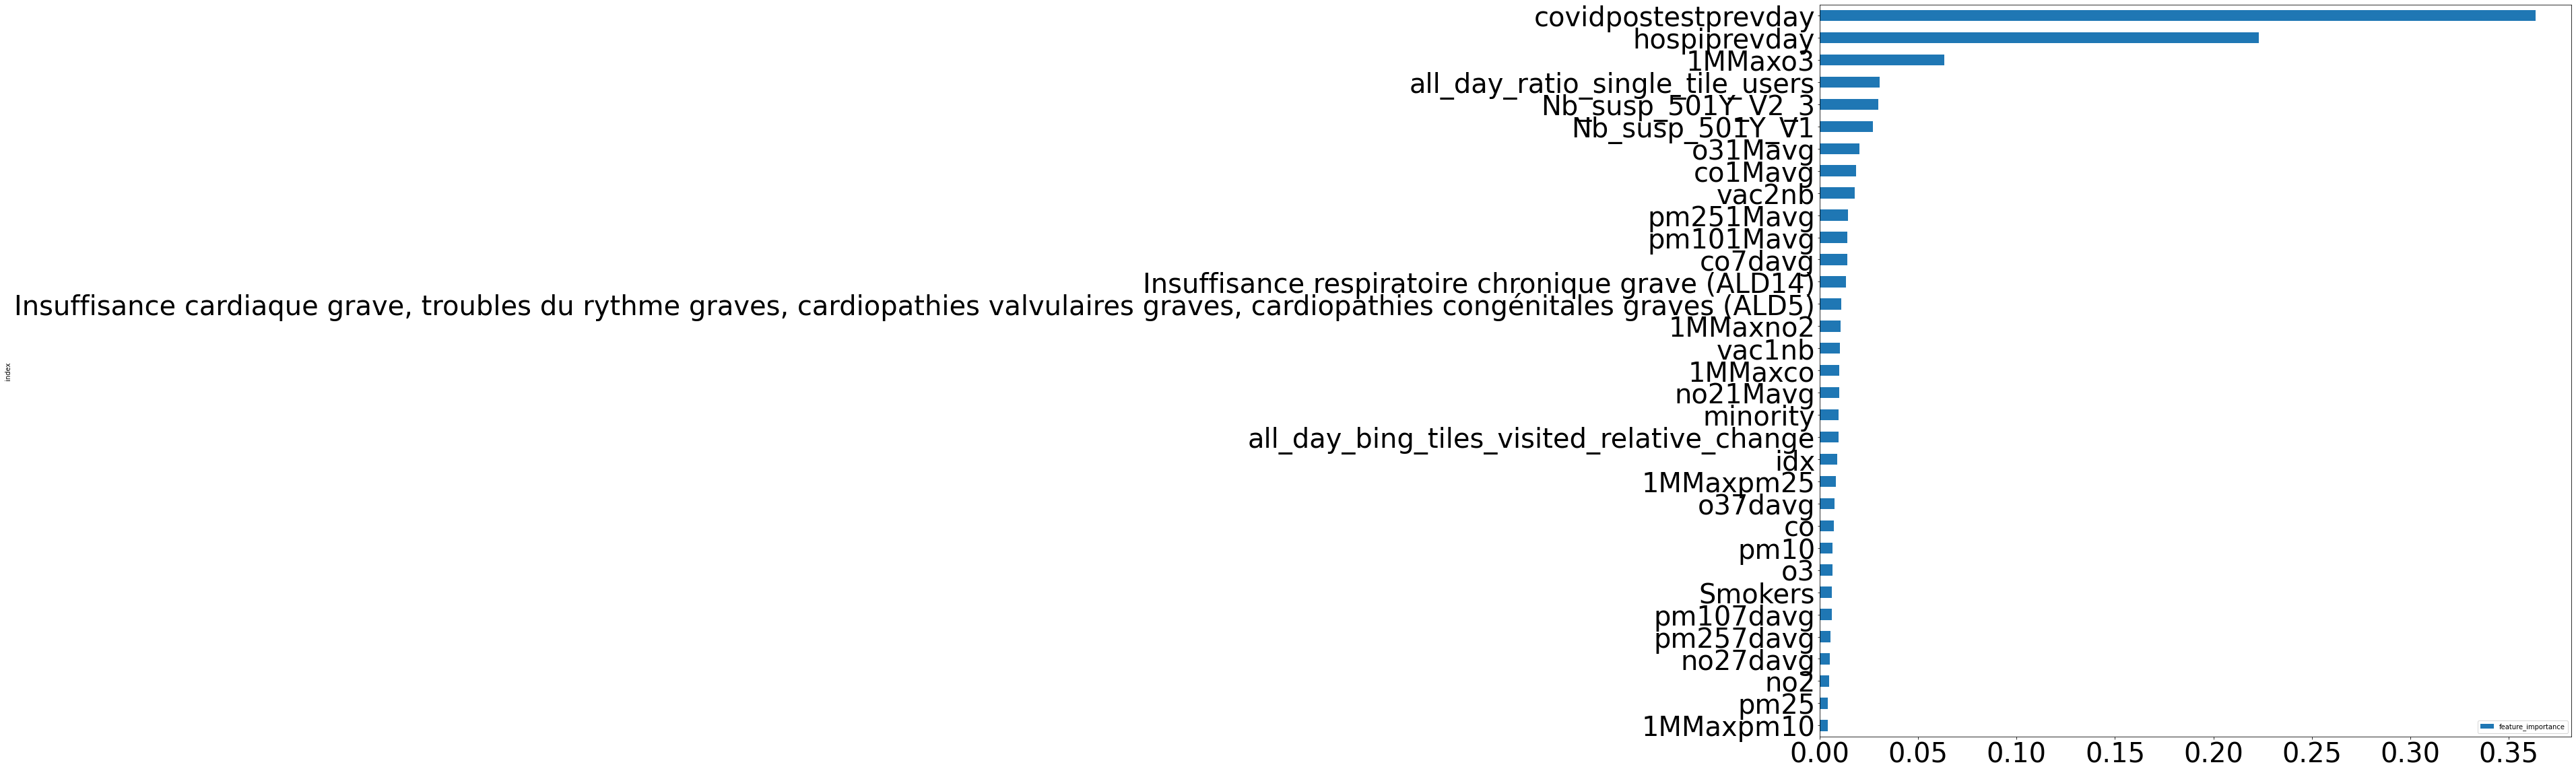

In [14]:
print("Scikit Learn - Extra Trees Regressor Feature importance report:", exported_pipeline.feature_importances_)
FIlist = exported_pipeline.feature_importances_.tolist()
FIlistdf = pd.DataFrame(FIlist)
FIlistdf = FIlistdf.T
FIlistdf.columns = features
FIlistdf = FIlistdf.T.reset_index()
FIlistdf.columns = ["index","feature_importance"]
FIlistdf.sort_values(by = ["feature_importance"], inplace = True, ascending =True)
print(FIlistdf)
print("\n")
fig = plt.figure(dpi = 150)
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40) 
FIlistdf.plot.barh(x="index", y="feature_importance",figsize = (20,20))
plt.show() 


print("XGBoost- Extreme Gradient Regressor Feature importance report:", xgb_model.feature_importances_)
FIlist = xgb_model.feature_importances_.tolist()
FIlistdf = pd.DataFrame(FIlist)
FIlistdf = FIlistdf.T
FIlistdf.columns = features
FIlistdf = FIlistdf.T.reset_index()
FIlistdf.columns = ["index", "feature_importance"]
FIlistdf.sort_values(by = ["feature_importance"], inplace = True, ascending = True)
print(FIlistdf)
print("\n")
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40)
FIlistdf.plot.barh(x="index", y="feature_importance", figsize = (20,20))
plt.show() 


In [15]:
features3 = ["covidpostestprevday","hospiprevday","1MMaxo3","all_day_ratio_single_tile_users","Nb_susp_501Y_V1","Nb_susp_501Y_V2_3"]

In [16]:
#X3=df[features3]
X3 = df[features]
y= df['newhospi']
# Hold-out
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.33,random_state = 84)
print("\n")

In [17]:
xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [108]:
scores = cross_validate(xgb_model, X2, y, cv=10,
                        scoring=('neg_mean_squared_error',"neg_mean_absolute_error"),
                         return_train_score=True)
print(scores)

{'fit_time': array([10.73198557, 10.89487457, 10.87736011, 10.57761025, 10.29064751,
       10.72798634, 10.67624664, 10.85061479, 10.82229376, 10.30657291]), 'score_time': array([0.02993417, 0.02751112, 0.02622771, 0.02785707, 0.02451277,
       0.02149963, 0.03005576, 0.02294087, 0.0256803 , 0.02420211]), 'test_neg_mean_squared_error': array([ -70.03014945, -130.25809935, -105.91804081,  -51.85924466,
        -12.94678361,  -26.35686082,  -15.42768291,  -20.41867446,
        -28.21669741, -344.74310046]), 'train_neg_mean_squared_error': array([-15.92795672, -15.03788351, -14.91440689, -15.34816714,
       -17.53498109, -17.33951274, -17.77175253, -17.32844251,
       -16.35632542, -13.31901557]), 'test_neg_mean_absolute_error': array([ -4.49631958,  -6.42726427,  -5.46770089,  -4.34256285,
        -2.07954316,  -3.01246407,  -2.25969306,  -2.74345294,
        -3.16612413, -11.99596175]), 'train_neg_mean_absolute_error': array([-2.49710219, -2.41292479, -2.41692231, -2.45922537, -2.63

In [84]:
print(scores["test_neg_mean_squared_error"].mean())
print(scores["test_neg_mean_absolute_error"].mean())

-82.44243014806173
-4.698829940830465


In [85]:
exported_pipeline = ExtraTreesRegressor(n_estimators=70, n_jobs=4, min_samples_split=11,
                            min_samples_leaf=1, max_features=0.94589)


In [93]:
X2 = df[df["time"]>pd.to_datetime("2020-10-20")][features]
y = df[df["time"]>pd.to_datetime("2020-10-20")]["newhospi"]
scores = cross_validate(exported_pipeline, X2, y, cv=5,
                        scoring=('neg_mean_squared_error',"neg_mean_absolute_error"),
                         return_train_score=True)
print(scores)

{'fit_time': array([0.91364264, 0.90254307, 0.9029448 , 0.90931368, 0.91571712]), 'score_time': array([0.02500224, 0.02798557, 0.02445483, 0.02698612, 0.02687335]), 'test_neg_mean_squared_error': array([-179.13365214, -101.30232724,  -48.33868579,  -33.37408419,
       -149.63904408]), 'train_neg_mean_squared_error': array([-13.21460653, -15.71826485, -18.35401867, -18.25030484,
       -14.92953268]), 'test_neg_mean_absolute_error': array([-8.3785052 , -6.96614382, -4.89785348, -4.23426685, -8.84056028]), 'train_neg_mean_absolute_error': array([-2.33694768, -2.4465338 , -2.74105885, -2.72272074, -2.38548884])}


In [94]:
print(scores["test_neg_mean_squared_error"].mean())
print(scores["test_neg_mean_absolute_error"].mean())

-102.35755868985419
-6.663465925984862


In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

In [ ]:
#from sklearn.model_selection import GridSearchCV
#print(exported_pipeline.get_params)
#parameters = {'max_features': np.arange(0,1,0.01), 'min_samples_split': np.arange(0,10,1)}
#ET = ExtraTreesRegressor()
#clf = GridSearchCV(ET, parameters)
#clf.fit(X_train2, y_train2)
#print(sorted(clf.cv_results_.keys()))

In [ ]:
featuresmini = ["hospiprevday",\
"covidpostestprevday",\
"idx",\
"1MMaxo3",\
"o31Mavg",\
"Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)",\
"all_day_ratio_single_tile_users",\
"Insuffisance respiratoire chronique grave (ALD14)",\
"1MMaxno2",\
"minority",\
"co1Mavg",\
"no21Mavg",\
"pm251Mavg",\
"all_day_bing_tiles_visited_relative_change",\
"co7davg",\
"1MMaxco",\
"no27davg",\
"Nb_susp_501Y_V1"]


In [57]:
from sklearn.model_selection import GridSearchCV
X_train_mini = X_train2[features]
X_test_mini = X_test2[features]
model = ExtraTreesRegressor(n_estimators=70, n_jobs=4, min_samples_split=11,
                            min_samples_leaf=1, max_features=0.94589)
                            
# gsc = GridSearchCV(
#     estimator=model,
#     param_grid={
#         #'n_estimators': range(69,71,1)
#         #'max_features': np.arange(float(0.944),float(0.946),0.0001),
#         #min_samples_leaf': range(1,10,1),
#         #'min_samples_split': range(10,12,1),
#     },
#     scoring=('neg_mean_squared_error'),
#     cv=5
# )

# grid_result = gsc.fit(X_train2, y_train2)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# print(grid_result.cv_results_)
# #for test_mean, train_mean, param in zip(
#        grid_result.cv_results_['mean_test_score'],
#        grid_result.cv_results_['mean_train_score'],
#        grid_result.cv_results_['params']):
#    print("Train: %f // Test : %f with: %r" % (train_mean, test_mean, param))
    
# model = ExtraTreesRegressor(**grid_result.best_params_)

model.fit(X_train_mini, y_train2)
predictions = model.predict(X_test_mini)
print("MSE")
print(mse(y_test2, predictions))
print("MAE")
print(mae(y_test2, predictions))






MSE
48.89046049667929
MAE
3.577414020788495


Scikit Learn - Extra Trees Regressor Feature importance report:
                                                index  feature_importance
22                                  Nb_susp_501Y_V2_3            0.002725
10                                          pm107davg            0.003117
6                                           pm257davg            0.003205
1                                                pm25            0.003213
7                                            no27davg            0.003314
4                                                pm10            0.003369
2                                                 no2            0.003535
3                                                  o3            0.003949
15                                             vac1nb            0.004647
5                                                  co            0.004717
16                                             vac2nb            0.004820
19                                            Sm

<Figure size 900x600 with 0 Axes>

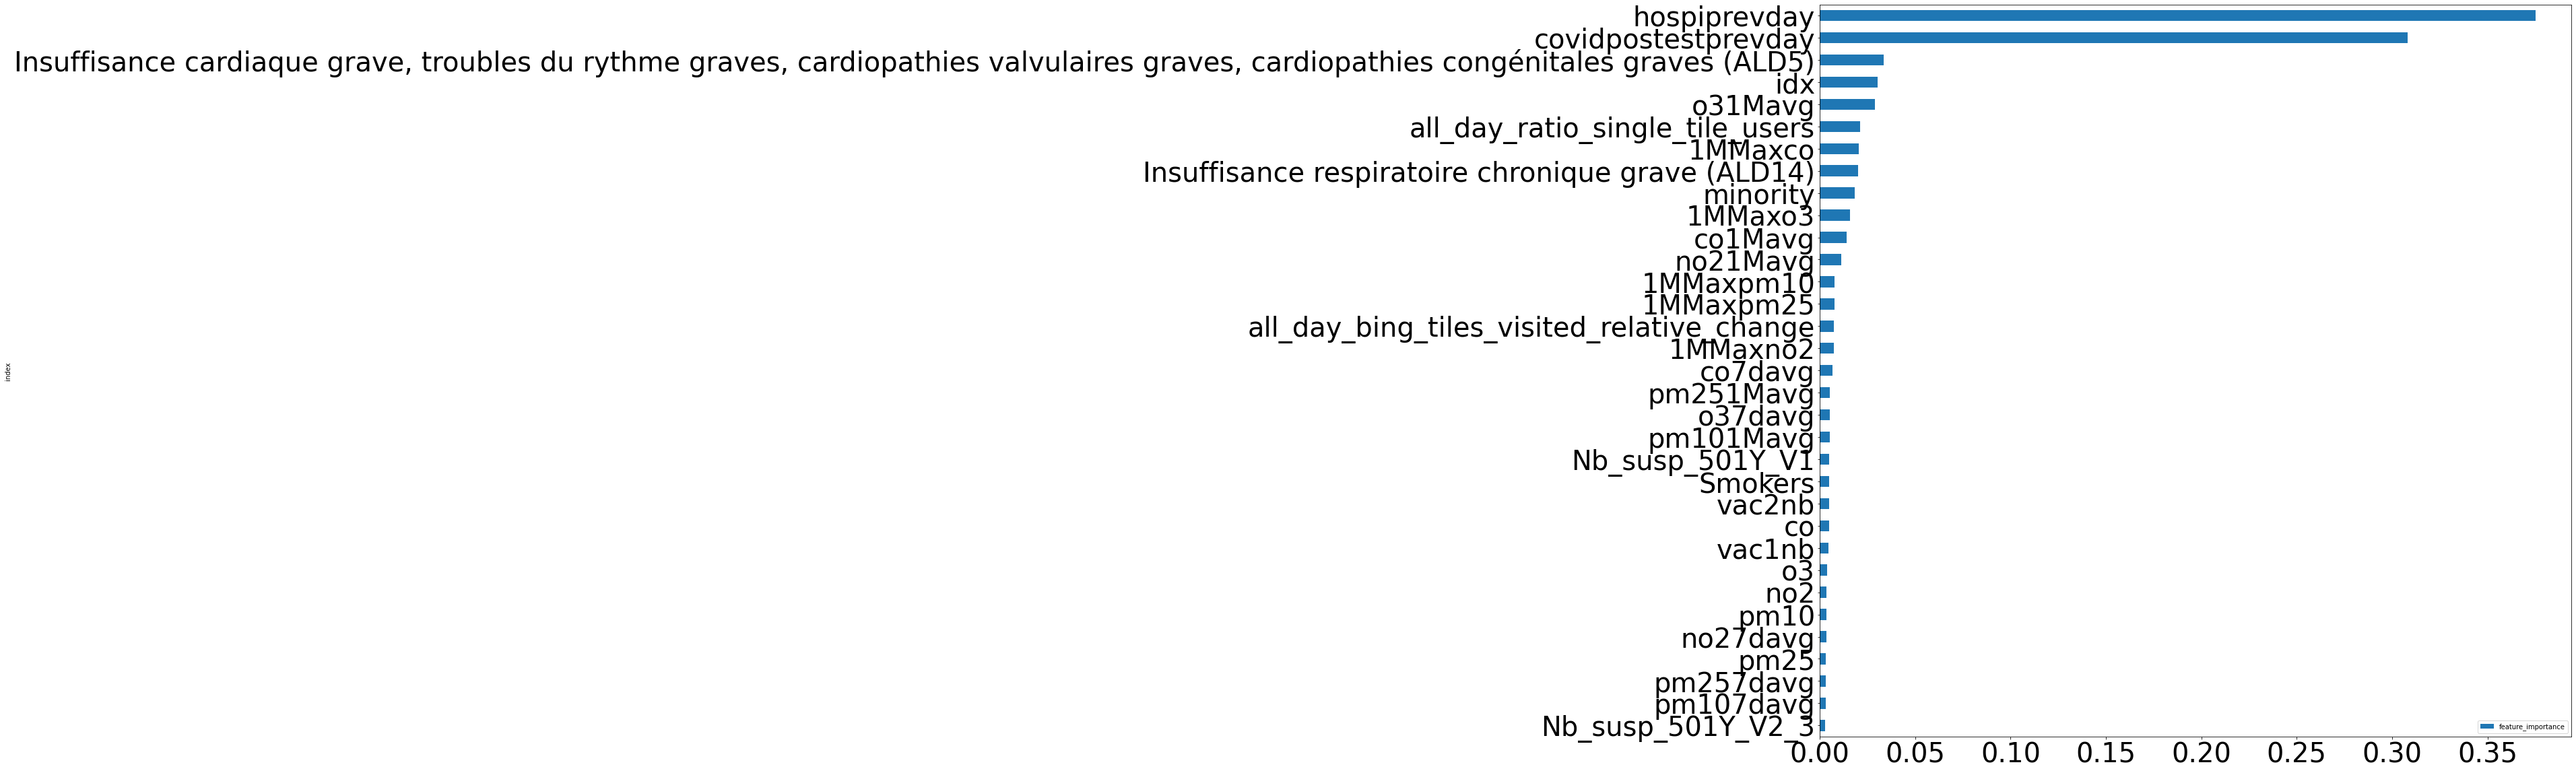

In [58]:
print("Scikit Learn - Extra Trees Regressor Feature importance report:")
FIlist = model.feature_importances_.tolist()
FIlistdf = pd.DataFrame(FIlist)
FIlistdf = FIlistdf.T
FIlistdf.columns = features
FIlistdf = FIlistdf.T.reset_index()
FIlistdf.columns = ["index","feature_importance"]
FIlistdf.sort_values(by = ["feature_importance"], inplace = True, ascending =True)
FIlistdf.to_csv("../feature_importance_Extra_Trees.csv")
print(FIlistdf)
print("\n")
fig = plt.figure(dpi = 150)
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40) 
FIlistdf.plot.barh(x="index", y="feature_importance",figsize = (20,20))
plt.show() 

In [59]:




#Save model to .joblib file
# save the model to disk
filename = '../model/model.joblib'
joblib.dump(ensemble, filename)
 
# # some time later...
 
# # load the model from disk
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)
# print(result)



print("\n")
print("TPOTRegressor")
tpot = TPOTRegressor(generations=50, population_size=50, verbosity=1, random_state=42)
tpot.fit(X_train2, y_train2)
print(tpot.score(X_test2, y_test2))
tpot.export('tpot_covid_pipeline.py')

print("\n")




TPOTRegressor


Version 0.11.6.post1 of tpot is outdated. Version 0.11.7 was released Wednesday January 06, 2021.




TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=1.0, min_samples_leaf=3, min_samples_split=5, n_estimators=100)
-50.109349638278964




In [ ]:
print("Neural Network")
X_trainNN = X_train2.values.reshape(X_train2.shape[0], X_train2.shape[1], 1)
y_trainNN = y_train2.values
X_testNN = X_test2.values.reshape(X_test2.shape[0],X_test2.shape[1],1)
y_testNN = y_test2.values
NNmodel = Sequential()
#NNmodel.add(layers.Dense(215, input_shape=(X_trainNN.shape[0], X_trainNN.shape[1])))
NNmodel.add(layers.LSTM(units=22, activation='tanh',return_sequences=True, input_shape=X_trainNN.shape[1:]))
NNmodel.add(layers.LSTM(units=10, activation='tanh', return_sequences=False))
NNmodel.add(layers.Dense(1, activation="linear"))

# The compilation
NNmodel.compile(loss='mse', 
              optimizer='rmsprop')

es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)

# The fit
NNmodel.fit(X_trainNN, y_trainNN,
         batch_size=16, validation_split = 0.3,
         epochs=100, verbose=1,callbacks=[es])

# The prediction
print("MSE:")
print(NNmodel.evaluate(X_testNN, y_testNN, verbose=0))

#print('validation loss (MSE):', val_loss, '\n validation MAE:', val_mae)
#print("Average error on new number of hospitalizations per day:", round(val_mae ** 0.5,0))